In [21]:
from utils import *
from torchvision.models.detection import SSD300_VGG16_Weights, ssd300_vgg16
import os
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from contextlib import nullcontext
from torch.utils.data import random_split
from torch import Tensor
import torch



In [22]:
# from google.colab import drive
# drive.mount('/content/drive')
DATASET_FOLDER = 'test_dataset'
IMG_HEIGHT = 2703
IMG_WIDTH = 4800


In [23]:
class PlanesDataset(Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.images = list(sorted(os.listdir(os.path.join(root, f"{DATASET_FOLDER}/images"))))
        self.labels = list(sorted(os.listdir(os.path.join(root, f"{DATASET_FOLDER}/labels"))))

    def load_bboxes(self, idx: int) -> list[float]:
        label_path = os.path.join(self.root, f"{DATASET_FOLDER}/labels", self.labels[idx])
        bboxes = []
        with open(label_path, 'r') as f:
            for line in f:
                bbox = (list(map(float, line.split()[1:])))
                to_absolute_bbox_format(bbox, IMG_WIDTH, IMG_HEIGHT)
                bboxes.append(bbox)
        bboxes = box_convert(torch.as_tensor(bboxes), in_fmt='cxcywh', out_fmt='xyxy')
        return bboxes

    def load_image(self, idx: int) -> Tensor:
        image_path = os.path.join(self.root, f"{DATASET_FOLDER}/images", self.images[idx])
        image = read_image(image_path).float() / 255
        return image

    def __getitem__(self, idx: int) -> tuple[Tensor, Tensor]:
        bboxes = self.load_bboxes(idx) # return list of [xmin, ymin, xmax, ymax]
        image = self.load_image(idx) # return an image tensor in shape [3, H, W]
        bbox_count = len(bboxes)

        labels = torch.ones((bbox_count,), dtype=torch.int64) # 1 - plane, 0 - background
        target = {
            "boxes": bboxes,
            "labels": labels,
        }

        # if self.transforms is not None:
        #   img, target = self.transforms(image, target)
        return image, target


    def __len__(self) -> In:
        return len(self.images)

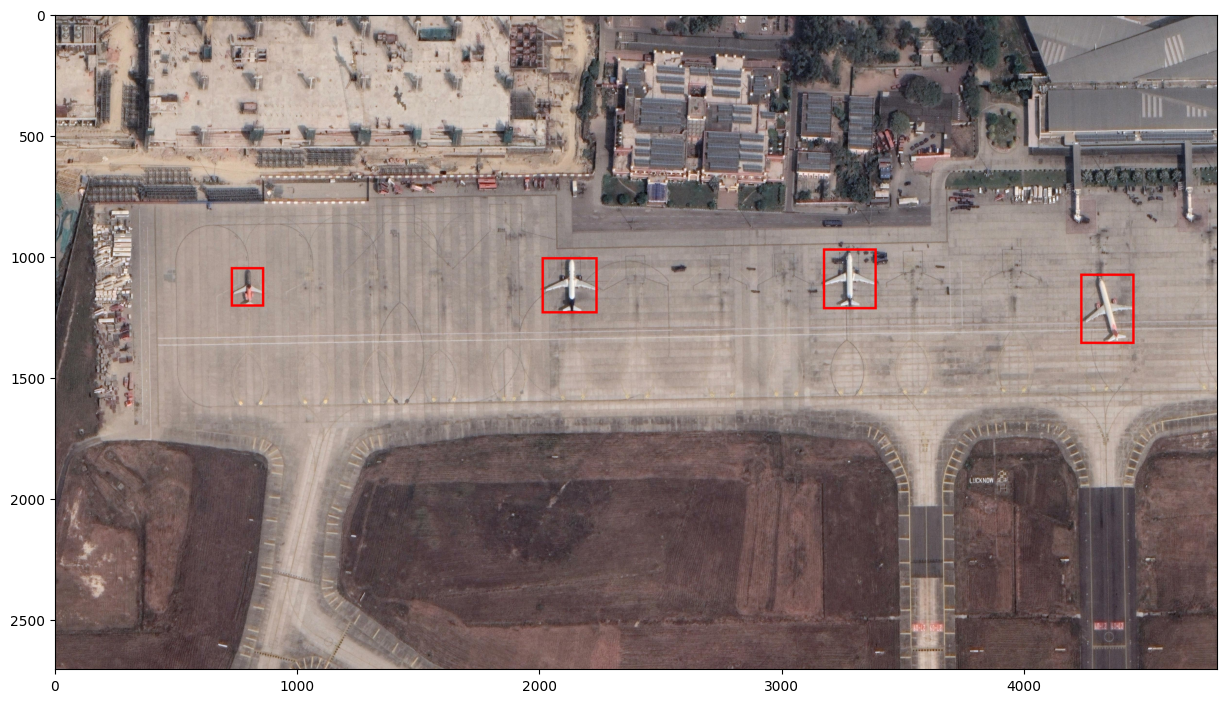

In [24]:

dataset = PlanesDataset("", None)

indices = torch.randperm(len(dataset)).tolist()
test_dataset, train_dataset = random_split(dataset, [0.05, 0.95], generator=torch.Generator().manual_seed(42))

with nullcontext():
    image, target = train_dataset[0]
    image = rescale_image(image)
    drawn_boxes = draw_bounding_boxes(image, target['boxes'], colors="red", width=10)
    plt.figure(figsize = (15, 10))
    plt.imshow(drawn_boxes.permute(1, 2, 0))

In [25]:
data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

In [26]:
weights = SSD300_VGG16_Weights.DEFAULT
model = ssd300_vgg16(weights=weights, trainable_backbone_layers=5)
device = torch.device('cpu')
model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(
    params,
    lr=0.001
)
num_epochs = 100
for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer,data_loader, epoch)

-------------- EPOCH 0 ---------------
{'bbox_regression': tensor(1.6574, grad_fn=<DivBackward0>), 'classification': tensor(5.5203, grad_fn=<DivBackward0>)}


In [ ]:
model.eval()
for images, targets in test_data_loader:
    with torch.no_grad():
        predictions = model(images)
        test_image_rescaled = rescale_image(image=images[0])
        drawn_boxes = draw_bounding_boxes(test_image_rescaled, predictions[0]['boxes'], colors="red", width=10)
        plt.figure(figsize = (15, 10))
        plt.imshow(drawn_boxes.permute(1, 2, 0))

In [ ]:
torch.save(model.state_dict(), 'saved_model.pth')